In [31]:
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import shap
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

### Import the test data and xgboost model for PD model

In [32]:
# Load xgboost model
model = joblib.load("../models/xgboost_model.joblib")
# Load test data for ROC curve
test_data = pd.read_csv("../data/feature_data/loan_data_test.csv")
test_target = test_data["DefaultTarget_12m"]
test_features = test_data.drop(columns=["DefaultTarget_12m"])

### Plot vanilla feature importance from XGboost(Gain and Cover)
 - This only shows the relative importance of features in the model
 - No positive or negative direction

In [33]:
def plot_xgb_importance(model, importance_type="gain", top_n=20, title=None):
    """
    Professional feature importance plot for XGBoost with rounded values.
    importance_type: "gain", "cover", "weight", "total_gain", "total_cover"
    """

    # Extract importance
    importance_dict = model.get_booster().get_score(importance_type=importance_type)

    # Convert to DataFrame
    imp_df = (
        pd.DataFrame.from_dict(importance_dict, orient="index", columns=["importance"])
          .reset_index()
          .rename(columns={"index": "feature"})
          .sort_values("importance", ascending=False)
          .head(top_n)
    )

    # Normalize to relative importance (optional but looks better)
    imp_df["importance_pct"] = imp_df["importance"] / imp_df["importance"].sum()

    # Round values
    imp_df["importance"] = imp_df["importance"].round(2)
    imp_df["importance_pct"] = (imp_df["importance_pct"] * 100).round(2)

    # Plot
    plt.figure(figsize=(8, max(5, top_n * 0.4)))
    sns.barplot(data=imp_df, x="importance_pct", y="feature")

    plt.xlabel("Relative Importance (%)")
    plt.ylabel("Feature")
    plt.title(title or f"Top {top_n} Features by {importance_type.capitalize()}")

    # Annotate values
    for index, row in imp_df.iterrows():
        plt.text(
            row["importance_pct"] * 1.01,
            imp_df.index.get_loc(index),
            f"{row['importance_pct']}%",
            va="center"
        )

    plt.tight_layout()
    plt.show()

    return imp_df

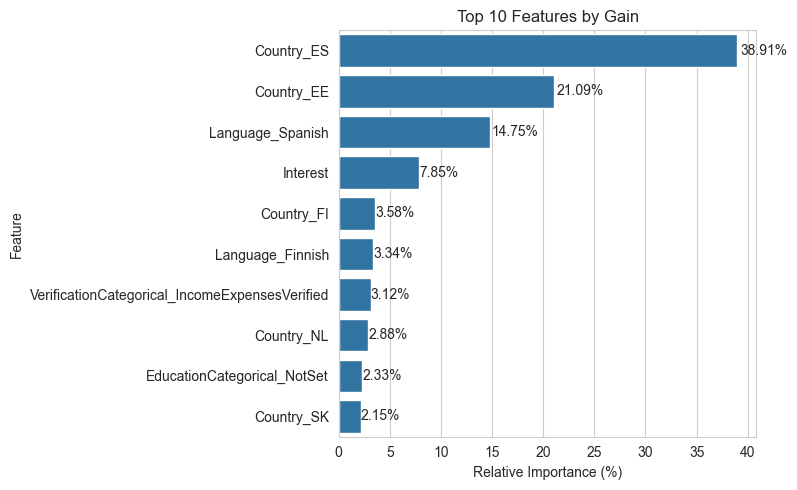

,feature,importance,importance_pct
36,Country_ES,306.09,38.91
35,Country_EE,165.92,21.09
85,Language_Spanish,116.01,14.75
13,Interest,61.71,7.85
37,Country_FI,28.18,3.58
82,Language_Finnish,26.30,3.34
40,VerificationCategorical_IncomeExpensesVerified,24.51,3.12
38,Country_NL,22.66,2.88
46,EducationCategorical_NotSet,18.32,2.33
39,Country_SK,16.93,2.15


In [34]:
plot_xgb_importance(model, importance_type="gain", top_n=10)

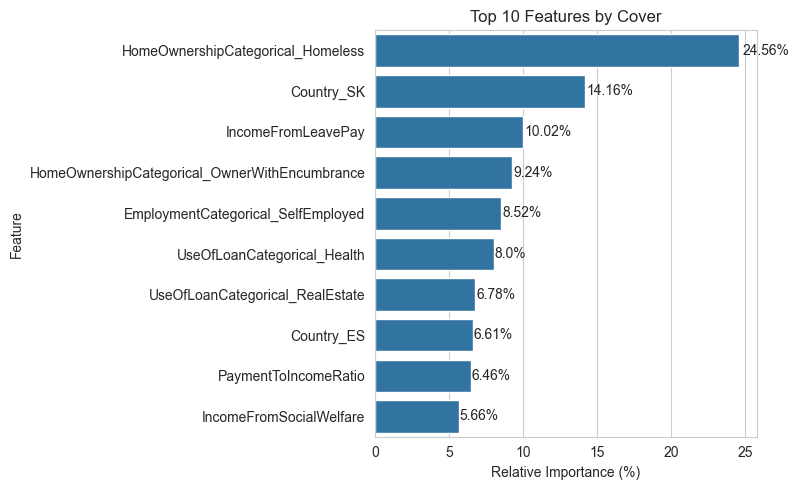

,feature,importance,importance_pct
60,HomeOwnershipCategorical_Homeless,23107.10,24.56
39,Country_SK,13321.28,14.16
5,IncomeFromLeavePay,9429.85,10.02
67,HomeOwnershipCategorical_OwnerWithEncumbrance,8697.52,9.24
54,EmploymentCategorical_SelfEmployed,8013.94,8.52
72,UseOfLoanCategorical_Health,7524.38,8.00
77,UseOfLoanCategorical_RealEstate,6380.02,6.78
36,Country_ES,6221.35,6.61
20,PaymentToIncomeRatio,6076.34,6.46
4,IncomeFromSocialWelfare,5322.09,5.66


In [35]:
plot_xgb_importance(model, top_n=10, importance_type="cover")

### Plot ROC-AUC Curve
 - This is a comparison of our classifier's performance against a random classifier
 - The closer the curve is to the top left corner, the better the classifier
 - The area under the curve (AUC) is a measure of the classifier's ability to distinguish between positive and negative classes

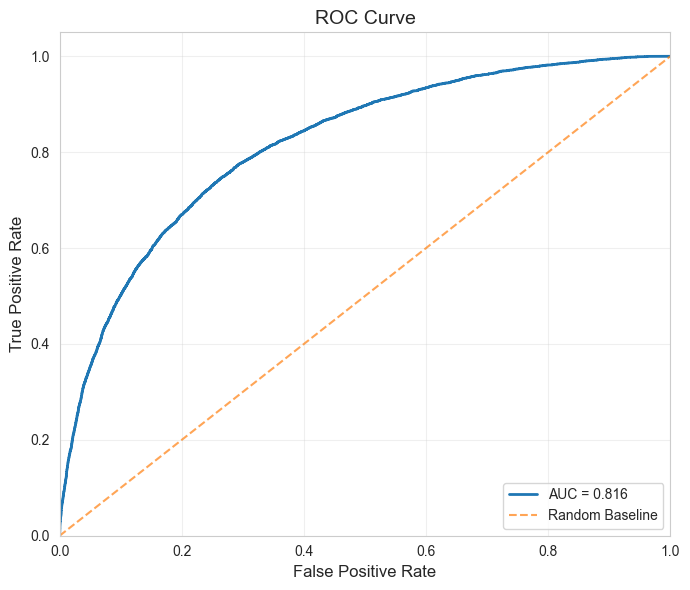

0.8158964121631653

In [36]:
y_pred_proba = model.predict_proba(test_features)[:, 1]

def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    
    # Compute ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(7, 6))
    sns.set_style("whitegrid")

    plt.plot(
        fpr, tpr,
        linewidth=2,
        label=f"AUC = {roc_auc:.3f}",
        solid_capstyle="round"
    )

    # Diagonal (random classifier)
    plt.plot(
        [0, 1], [0, 1],
        linestyle="--",
        linewidth=1.5,
        alpha=0.7,
        label="Random Baseline"
    )

    # Formatting
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return roc_auc
plot_roc_curve(test_target, y_pred_proba)


### Calibration Plots

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_7044/2488819700.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bucket").agg(


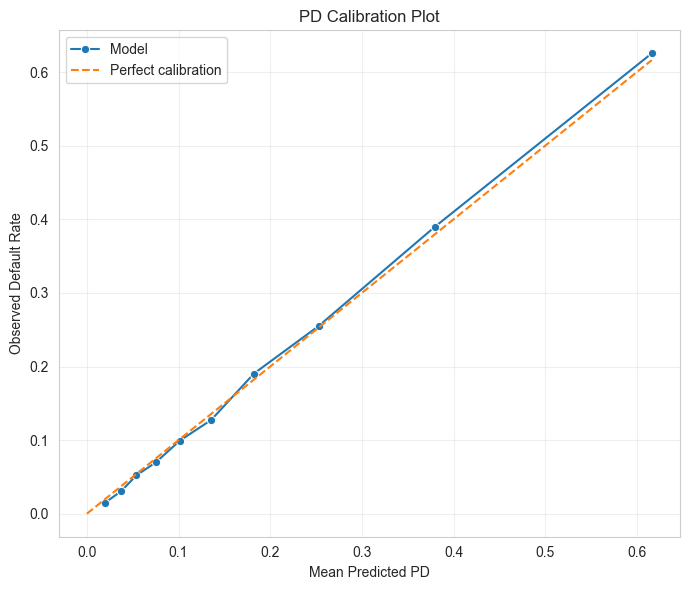

,bucket,mean_predicted,actual_rate,count
0,"(0.00145, 0.0293]",0.019664,0.014901,3087
1,"(0.0293, 0.0454]",0.037266,0.030450,3087
2,"(0.0454, 0.0637]",0.054064,0.052154,3087
3,"(0.0637, 0.0875]",0.075053,0.069647,3087
4,"(0.0875, 0.117]",0.101584,0.099449,3087
5,"(0.117, 0.156]",0.135561,0.127308,3087
6,"(0.156, 0.213]",0.182315,0.190476,3087
7,"(0.213, 0.301]",0.252729,0.254940,3087
8,"(0.301, 0.477]",0.379488,0.389699,3087
9,"(0.477, 0.983]",0.616307,0.625526,3087


In [37]:
def plot_pd_calibration(y_true, y_pred_proba, bins=10, title="PD Calibration Plot"):
    
    df = pd.DataFrame({
        "actual": y_true,
        "predicted": y_pred_proba
    })

    # Create bins based on predicted PD
    df["bucket"] = pd.qcut(df["predicted"], bins, duplicates="drop")

    # Compute mean predicted PD & actual rate per bucket
    calib = df.groupby("bucket").agg(
        mean_predicted=("predicted", "mean"),
        actual_rate=("actual", "mean"),
        count=("actual", "count")
    ).reset_index()

    # Plot
    plt.figure(figsize=(7, 6))
    sns.lineplot(x="mean_predicted", y="actual_rate", data=calib, marker="o", label="Model")

    # Perfect calibration line
    x = np.linspace(0, calib["mean_predicted"].max(), 100)
    plt.plot(x, x, linestyle="--", label="Perfect calibration")

    # Formatting
    plt.xlabel("Mean Predicted PD")
    plt.ylabel("Observed Default Rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return calib

plot_pd_calibration(test_target, y_pred_proba)


/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_7044/2031551805.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ks_table = df.groupby("bucket").agg(


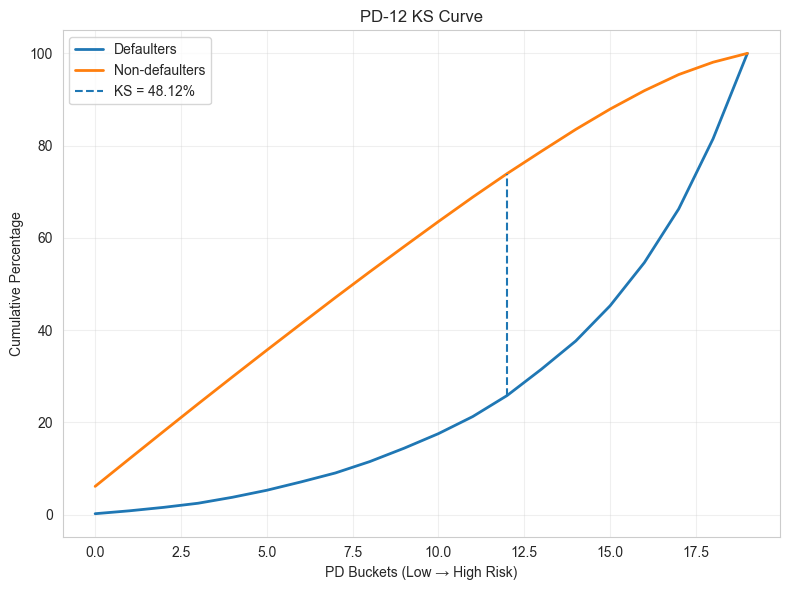

In [38]:
def plot_ks_curve(y_true, y_pred_proba, bins=20, title="KS Curve"):
    
    df = pd.DataFrame({
        "actual": y_true,
        "score": y_pred_proba
    }).sort_values("score")

    # Define good / bad
    df["bad"] = (df["actual"] == 1).astype(int)
    df["good"] = (df["actual"] == 0).astype(int)

    # Create buckets by predicted PD
    df["bucket"] = pd.qcut(df["score"], bins, duplicates="drop")

    # Aggregate
    ks_table = df.groupby("bucket").agg(
        bad=("bad", "sum"),
        good=("good", "sum"),
        total=("actual", "count")
    ).reset_index()

    # Cumulative distributions
    ks_table["cum_bad_pct"] = ks_table["bad"].cumsum() / ks_table["bad"].sum() * 100
    ks_table["cum_good_pct"] = ks_table["good"].cumsum() / ks_table["good"].sum() * 100

    # KS value
    ks_table["ks"] = np.abs(ks_table["cum_bad_pct"] - ks_table["cum_good_pct"])
    ks_value = ks_table["ks"].max()
    ks_idx = ks_table["ks"].idxmax()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=ks_table.index, y="cum_bad_pct", data=ks_table, label="Defaulters", linewidth=2)
    sns.lineplot(x=ks_table.index, y="cum_good_pct", data=ks_table, label="Non-defaulters", linewidth=2)

    # Draw KS vertical line
    plt.vlines(
        x=ks_idx,
        ymin=ks_table.loc[ks_idx, "cum_bad_pct"],
        ymax=ks_table.loc[ks_idx, "cum_good_pct"],
        linestyles="--",
        label=f"KS = {ks_value:.2f}%"
    )

    # Formatting
    plt.xlabel("PD Buckets (Low → High Risk)")
    plt.ylabel("Cumulative Percentage")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return ks_value, ks_table

ks_value, ks_table = plot_ks_curve(
    test_target,
    y_pred_proba,
    bins=20,
    title="PD-12 KS Curve"
)


### Plot Shap intepretability plots
 - This will help us understand the impact and direction of each feature on the prediction

Using 10000 samples for SHAP computation (out of 30870 total)
SHAP summary plots saved!


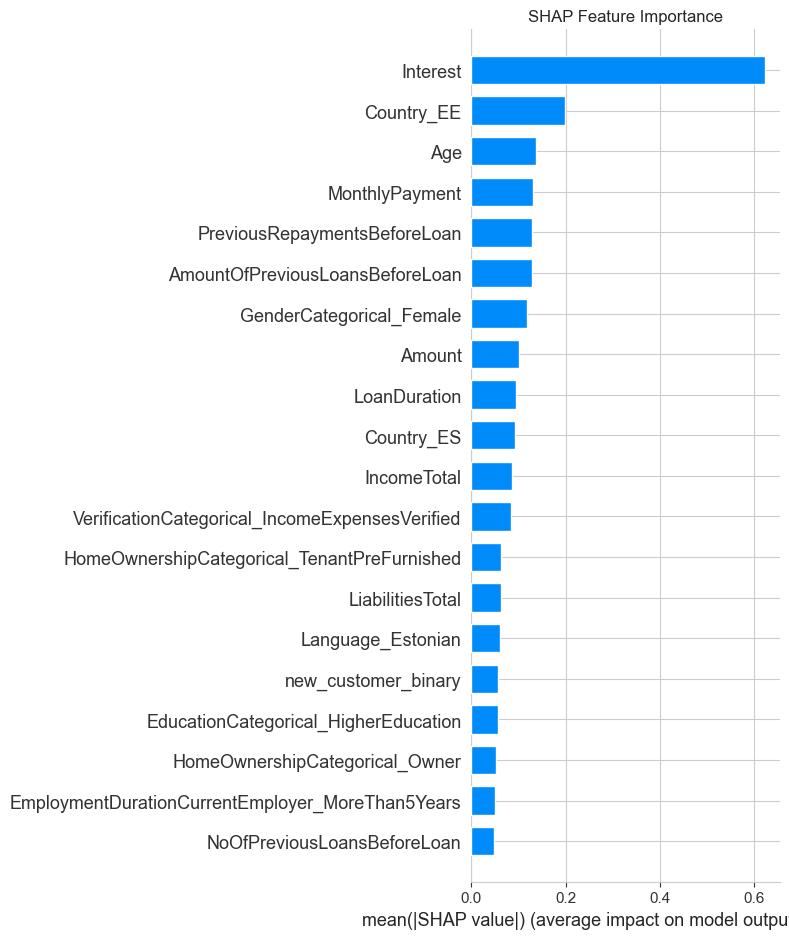

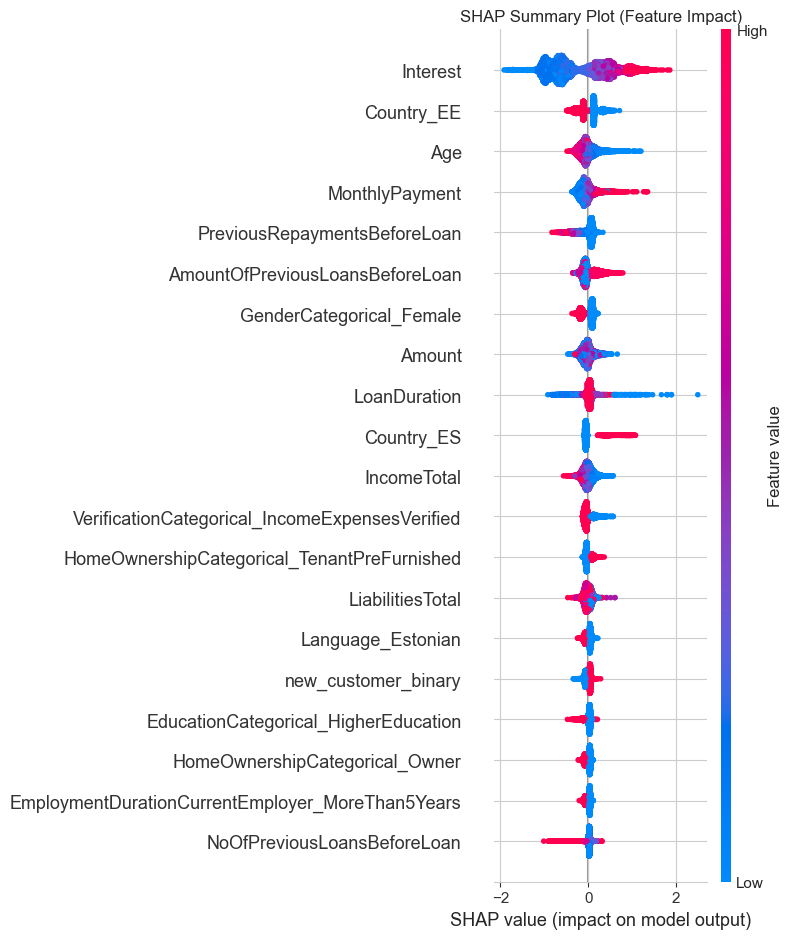

In [39]:

def shap_summary_plot(model: XGBClassifier, data: pd.DataFrame, sample_size: int = 10000) -> None:
    """Generate SHAP summary plot showing feature importance and impact direction."""
    
    # Sample data for faster computation
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42)
        print(f"Using {sample_size} samples for SHAP computation (out of {len(data)} total)")
    else:
        data_sample = data
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_sample)
    
    # Summary plot (bar)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, data_sample, plot_type="bar", show=False, max_display=20)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    
    # Summary plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, data_sample, show=False, max_display=20)
    plt.title("SHAP Summary Plot (Feature Impact)")
    plt.tight_layout()

    
    print("SHAP summary plots saved!")

shap_summary_plot(model, test_features)